> ### EEE4423: Signal Processing Lab

# LAB \#3: CNN: VGG Net and ResNet [CoLab]

<h4><div style="text-align: right"> Due date: March 29, 2019.  </div> <br>
<div style="text-align: right"> Please upload your file @ yscec by 9 AM in the form of [ID_Name_Lab3.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2015142113] [JunYoung Kim]</span> </h2>

In [0]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2020-06-03 14:39:04.205665


In [0]:
#####################################################################
# In order to use GPU acceleration, you must change runtime type.
# See the menu bar above. 
# "Runtime" -> "Change runtime type"  -> "Hardware accelerator"
# Change 'None' to 'GPU', then run the code below.
#####################################################################

import sys
import platform
import torch

print("Python version")
print(sys.version_info)

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)

OS information
Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic

Is GPU available?
True

GPU information
Wed Jun  3 14:39:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                    

## 1. VGGNet with PyTorch

### Implementing VGGNet

> 1. **Dataset**
>> - Images from the first three categories in CIFAR-10. (Due to the computational constraints.)  <br>
     Three categories : plane, car, bird  /  The number of training images : 15,000   /  The number of test images : 3,000
>> - Augmented with flipping and random cropping.
>
> 2. **Network architecture**
>> - Type-D configuration in the paper (+ 3-way classifier after convolutional layers).
>> - ReLU activation.
>> - No dropout for simplicity.
>> - We will apply **batch-normalization** after every convolution which is not used in the paper (otherwise, hard to optimize).
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1OiTmrplD9gOrEJizLChyLp31R0QtoeHv" alt="no_image" style="width: 550px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1bBvAOdJeskMMyOrZtBCCnkEEgq9PgjX9" alt="no_image" style="width: 250px;"/> </td>
>> </tr></table>
>>
>> <font size="0.5"> Figure from <br>
>> [1] https://www.quora.com/What-is-the-VGG-neural-network </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
     Note that `nn.CrossEntroyLoss` takes logits before softmax as network outputs and scalar index (not one-hot vector) as ground-truths.<br>
     See https://pytorch.org/docs/stable/nn.html#crossentropyloss for details.
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 20 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
> 

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets 
import torchvision
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
print('STEP 1: LOADING DATASET')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = dsets.CIFAR10(root='./data/CIFAR10/', 
                            train=True, 
                            transform=transform_train,
                            download=True)

test_dataset = dsets.CIFAR10(root='./data/CIFAR10/', 
                           train=False, 
                           transform=transform_test)

STEP 1: LOADING DATASET


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10/


In [0]:
# reducing the dataset
reduced_train_dataset = []
for images, labels in train_dataset:
    if labels < 3:
        reduced_train_dataset.append((images, labels))
        
reduced_test_dataset = []
for images, labels in test_dataset:
    if labels < 3:
        reduced_test_dataset.append((images, labels))

In [4]:
print("The number of training images : ", len(reduced_train_dataset))
print("The number of test images : ", len(reduced_test_dataset))

The number of training images :  15000
The number of test images :  3000


In [5]:
print('STEP 2: MAKING DATASET ITERABLE')

train_loader = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=reduced_test_dataset, 
                                          batch_size=100, 
                                          shuffle=False)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

STEP 2: MAKING DATASET ITERABLE


### Visualize a few images

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

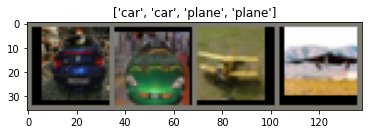

In [0]:
train_loader_sample = torch.utils.data.DataLoader(dataset=reduced_train_dataset, 
                                           batch_size=4, 
                                           shuffle=True)

# Get a batch of training data
inputs, classes = next(iter(train_loader_sample))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 1.1 Write code (VGG 16) [3 points]

In [0]:
print('STEP 3: CREATE MODEL CLASS (VGG16)')

def conv_type1(in_channels, out_channels):
    model = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    return model

def conv_type2(in_channels, out_channels):
    model = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    return model

class VGG16Model(nn.Module):
    def __init__(self):
        super(VGG16Model, self).__init__()
        self.conv = nn.Sequential(
            conv_type1(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            conv_type1(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            conv_type2(128, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            conv_type2(256, 512),
            nn.MaxPool2d(kernel_size=2, stride=2),
            conv_type2(512, 512),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(1*1*512, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1000),
            nn.ReLU(),
            nn.Linear(1000, 3)
        )

    def forward(self, x):
        batch_size = x.size(0)
        out = self.conv(x)
        out = out.view(batch_size, -1)
        out = self.fc(out)
        return out

STEP 3: CREATE MODEL CLASS (VGG16)


In [0]:
model = VGG16Model()
num_total_params = sum(p.numel() for p in model.parameters())
print("The number of parameters : ", num_total_params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

The number of parameters :  20924387


VGG16Model(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [0]:
print('STEP 5: INSTANTIATE LOSS CLASS')
criterion = nn.CrossEntropyLoss()

print('STEP 6: INSTANTIATE OPTIMIZER CLASS')
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

STEP 5: INSTANTIATE LOSS CLASS
STEP 6: INSTANTIATE OPTIMIZER CLASS


### 1.2 Train the VGG 16 model and print test accuracy for every epochs [2 points]

In [0]:
print('STEP 7: TRAIN THE MODEL')
num_epochs = 20

for epoch in range(num_epochs):
    torch.cuda.synchronize()
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
    for i, (images, labels) in enumerate(train_loader):
        # (batchsize, channel, width & height)
        images = images.view(-1, 3, 32, 32).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()
    
    end.record()

    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 3, 32, 32).to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)

        if torch.cuda.is_available():
            correct += (predicted.cpu()==labels.cpu()).sum()
        else:
            correct += (predicted==labels).sum()
    accuracy = 100 * correct.item() / total
    print("epoch: {}, loss: {}, accuracy: {}, elapsed time: {} sec".format(epoch+1, loss, accuracy, start.elapsed_time(end)/1000))



STEP 7: TRAIN THE MODEL
epoch: 1, loss: 0.5998851656913757, accuracy: 82.3, elapsed time: 51.5581484375 sec
epoch: 2, loss: 0.4074307978153229, accuracy: 84.63333333333334, elapsed time: 51.561578125 sec
epoch: 3, loss: 0.20508195459842682, accuracy: 88.5, elapsed time: 51.68526171875 sec
epoch: 4, loss: 0.19014883041381836, accuracy: 89.86666666666666, elapsed time: 51.54236328125 sec
epoch: 5, loss: 0.06775260716676712, accuracy: 91.16666666666667, elapsed time: 51.447234375 sec
epoch: 6, loss: 0.22605951130390167, accuracy: 91.8, elapsed time: 51.40878125 sec
epoch: 7, loss: 0.05583304539322853, accuracy: 92.0, elapsed time: 51.4803671875 sec
epoch: 8, loss: 0.12267255783081055, accuracy: 90.53333333333333, elapsed time: 51.488171875 sec
epoch: 9, loss: 0.010541905649006367, accuracy: 90.93333333333334, elapsed time: 51.48362890625 sec


## 2. ResNet with PyTorch

### Implementing ResNet

> 1. **Dataset**
>> - The same dataset used for VGGNet
>
> 2. **Network architecture**
>> - 50-layer ResNet with **bottleneck blocks**. <br>
     Note. The initial convolution layer (i.e., conv1) is different from the one in the paper &<br>
     the initial max-pooling layer is removed (because the size of CIFAR-10 images is too small).
>> - ReLU activation.
>> - Strided convolution for down-sampling instead of max-pooling layer. <br>
     Note. Once down-sampled, a $1\times1$ convolution/stride 2 is applied to residual for expanding the channel of the residual.
>> - No dropout for simplicity.
>> - Batch-normalization after every convolution.
>>
>>
>> <table><tr>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1ZYDfpVBFBvQnVezVcJqRxwh09rUVmxwD" alt="no_image" style="width: 500px;"/> </td>
>> <td> <img src="https://docs.google.com/uc?export=download&id=1JNEea1G-5yOKVLmSCkiYAEJ0HXOys0CR" alt="no_image" style="width: 300px;"/> </td>
>> </tr></table>
>>
>> <img src="https://docs.google.com/uc?export=download&id=1vY0ys5KAZmMlOKk8Dcv7eAV8pZ9cawzJ" alt="no_image" style="width: 870px;"/>
>>
>> <font size="0.5"> Figures from <br> 
>> [1] https://www.codeproject.com/Articles/1248963/Deep-Learning-using-Python-plus-Keras-Chapter-Re  <br> 
>> [2] Rezende et al., *Signal Processing: Image Communication*, 2018. </font>
>
> 3. **Loss function**
>> - Cross-entropy loss between outputs & ground-truths. <br>
>
> 4. **Training**
>> - Default weight initialization for simplicity.
>> - SGD optimizer with `learning rate = 1e-2`, `momentum = 0.9`, and `weight_decay = 5e-4`.
>> - 15 epochs without learning rate scheduling.
>
> 5. **Evaluation metric**
>> - Classification accuracy (i.e., the percentage of correct predictions).
>
> 

### 2.1 Implement ResNet50 and train it with the CIFAR 10 dataset [4 points] 

In [14]:
print('STEP 3: CREATE MODEL CLASS')

def conv1(input_dim, output_dim):
    model = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(output_dim),
        nn.ReLU()
    )

    return model

class bottleneck(nn.Module):
    def __init__(self, input_dim, mid_dim, output_dim, stride):
        super(bottleneck, self).__init__()

        self.stride = stride
        self.conv = nn.Sequential(
            nn.Conv2d(input_dim, mid_dim, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(mid_dim),
            nn.ReLU(),
            nn.Conv2d(mid_dim, mid_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(mid_dim),
            nn.ReLU(),
            nn.Conv2d(mid_dim, output_dim, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(output_dim),
            nn.ReLU()
        )

        self.proj = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=2)
        self.bn = nn.BatchNorm2d(output_dim)
        self.relu = nn.ReLU()

        self.adjust = nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=1)


    def forward(self, x):

        if self.stride == 2:
            out = self.conv(x)
            proj = self.proj(x)
            out = out + self.bn(proj)

        else: 
            out = self.conv(x)
            if x.size() != out.size():
                x = self.adjust(x)
            out = out + x

        out = self.relu(out)
        return out

class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()

        self.conv1 = conv1(3, 64)
        self.conv2 = nn.Sequential(
            bottleneck(64, 64, 256, 1),
            bottleneck(256, 64, 256, 1),
            bottleneck(256, 64, 256, 1)
        )
        self.conv3 = nn.Sequential(
            bottleneck(256, 128, 512, 2),
            bottleneck(512, 128, 512, 1),
            bottleneck(512, 128, 512, 1)
        )
        self.conv4 = nn.Sequential(
            bottleneck(512, 256, 1024, 2),
            bottleneck(1024, 256, 1024, 1),
            bottleneck(1024, 256, 1024, 1)
        )
        self.conv5 = nn.Sequential(
            bottleneck(1024, 512, 2048, 2),
            bottleneck(2048, 512, 2048, 1),
            bottleneck(2048, 512, 2048, 1),
        )
        self.avgpool = nn.AvgPool2d(kernel_size=4)
        self.fc = nn.Linear(1*2048, 3)

    def forward(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)

        out = self.avgpool(out)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

print('STEP 4 : INSTANTIATE MODEL CLASS')
model = ResNet50Model()
num_params = sum(p.numel() for p in model.parameters())
print("Num of params : ", num_params)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

STEP 3: CREATE MODEL CLASS
STEP 4 : INSTANTIATE MODEL CLASS
Num of params :  44981763


ResNet50Model(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): bottleneck(
      (conv): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
      )
      (proj): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

### 2.2 Print test accuracy for every epochs. [1 points]

In [16]:
print('STEP 5 : INSTANTIATE LOSS CLASS')
criterion = nn.CrossEntropyLoss()

print('STEP 6 : INSTANTIATE OPTIMIZER CLASS')
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

print('STEP 7 : TRAIN THE MODEL')
num_epochs = 15
for epoch in range(num_epochs):
    torch.cuda.synchronize()
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
    avgloss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 3, 32, 32).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)
        avgloss += loss.item()

        loss.backward()

        optimizer.step()
        
    end.record()
    avgloss /= (i+1)
    
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 3, 32, 32).to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, prediction = torch.max(outputs.data, 1)
        total += labels.size(0)

        if torch.cuda.is_available():
            correct += (prediction.cpu()==labels.cpu()).sum()
        else:
            correct += (prediction==labels).sum()

    accuracy = 100 * correct.item() / total
    print("epoch: {}, loss: {}, accuracy: {}, elasped time: {} sec".format(epoch+1, avgloss, accuracy, start.elapsed_time(end)/1000))


STEP 5 : INSTANTIATE LOSS CLASS
STEP 6 : INSTANTIATE OPTIMIZER CLASS
STEP 7 : TRAIN THE MODEL
epoch: 1, loss: 0.7738632226394395, accuracy: 73.76666666666667, elasped time: 20.600958984375 sec
epoch: 3, loss: 0.6269372893592059, accuracy: 76.46666666666667, elasped time: 20.5766171875 sec
epoch: 4, loss: 0.6022863986633592, accuracy: 77.36666666666666, elasped time: 20.587625 sec
epoch: 5, loss: 0.62335904927577, accuracy: 77.53333333333333, elasped time: 20.590525390625 sec
epoch: 6, loss: 0.5482679373126919, accuracy: 78.0, elasped time: 20.58967578125 sec
epoch: 7, loss: 0.46437536306300403, accuracy: 78.33333333333333, elasped time: 20.584544921875 sec
epoch: 8, loss: 0.4365412203942315, accuracy: 78.46666666666667, elasped time: 20.59434375 sec
epoch: 9, loss: 0.40146990196179533, accuracy: 79.7, elasped time: 20.582484375 sec
epoch: 10, loss: 0.3693102647439908, accuracy: 79.6, elasped time: 20.584029296875 sec
epoch: 11, loss: 0.34988707733356345, accuracy: 75.3, elasped time: 2